## Run RouskinHF

In [2]:
from rouskinhf import convert

data = convert(
    'ct',
    '/Users/yvesmartin/data/archiveII',
    name='archiveII',
    path_out='data',
    filter=True
)

Parsing ct files:   0%|          | 0/3975 [00:00<?, ?it/s]

Parsing ct files: 100%|██████████| 3975/3975 [00:01<00:00, 3215.48it/s]


Over a total of 3975 datapoints, there are:
### OUTPUT
- ALL: 3486 valid datapoints
- INCLUDED: 26 duplicate sequences with different structure / dms / shape
### MODIFIED
- 1537 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 489 duplicate sequences with the same structure / dms / shape


## Visualise



<Axes: >

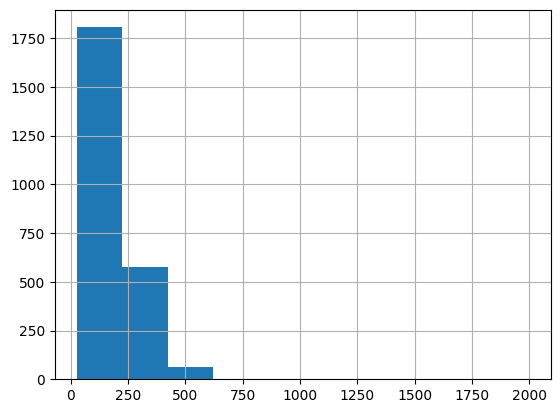

In [3]:
import pandas as pd

df = pd.read_json('data/archiveII/data.json', orient='index')
df.sequence.apply(len).hist(bins=10)

## Upload

In [ ]:
from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    'data/archiveII/data.json',
    commit_message='init commit.'
)